## Basic Setup

In [5]:
%pip install seaborn tikzplotlib
from transformers import T5ForConditionalGeneration, T5Tokenizer
import torch
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
import seaborn as sns
import tikzplotlib
import matplotlib.pyplot as plt

model = T5ForConditionalGeneration.from_pretrained('t5-small')
tokenizer = T5Tokenizer.from_pretrained('t5-small', legacy=True)

DF = pd.read_csv('../orcas.tsv', sep='\t', header=None, names=['query', 'docid'])
docid_counts = DF.groupby('docid').count()

def get_embeddings(n_docids, n_queries, min_pop, max_pop):
    """
    Get embeddings of queries grouped by documents

    Arguments:
    n_docids - number of docs
    n_queries - number of queries per doc
    min_pop - minimum popularity in terms of associated queries per doc
    max_pop - maximum popularity in terms of associated queries per doc
    """
    if min_pop is None:
        min_pop = n_queries
    elif min_pop < n_queries:
        raise Exception('min_pop cannot be smaller than n_queries')

    filter = (docid_counts['query'] >= min_pop)
    if max_pop is not None:
        filter &= (docid_counts['query'] < max_pop)
    
    eligible_docids = docid_counts[filter].index
    df = DF[DF['docid'].isin(eligible_docids)]
    sampled_docids = df['docid'].drop_duplicates().sample(n=n_docids)

    doc_embeddings = torch.empty((0, model.encoder.config.hidden_size), dtype=torch.float32)
    for docid in sampled_docids:
        queries = df[df['docid'] == docid].sample(n=n_queries)['query'].tolist()
        inputs = [tokenizer(query, return_tensors='pt').input_ids for query in queries]
        
        with torch.no_grad():
            query_embeddings = torch.stack([model.encoder(input_ids=input_ids).last_hidden_state.mean(dim=1) for input_ids in inputs]).squeeze(1)
        
        doc_embeddings = torch.cat((doc_embeddings, query_embeddings), dim=0)

    return doc_embeddings

Note: you may need to restart the kernel to use updated packages.


## Plotting

tensor([[ 0.0294,  0.1439, -0.0770,  ..., -0.0119, -0.0611, -0.0441],
        [ 0.0416,  0.1626, -0.0274,  ...,  0.0451, -0.0585, -0.1024],
        [ 0.0588,  0.1789, -0.0899,  ..., -0.1215,  0.0239, -0.0924],
        ...,
        [ 0.0654,  0.1419,  0.0014,  ...,  0.1861, -0.0474,  0.0715],
        [ 0.0870,  0.1084,  0.0942,  ...,  0.1466,  0.0568,  0.0377],
        [ 0.0465,  0.0758,  0.0749,  ...,  0.0570, -0.0114,  0.0521]])


/Users/marcel/anaconda3/envs/mtgjamendo/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/marcel/anaconda3/envs/mtgjamendo/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


<AxesSubplot:title={'center':'Query Clustering Grouped by Documents (Doc Popoularity None-None)'}>

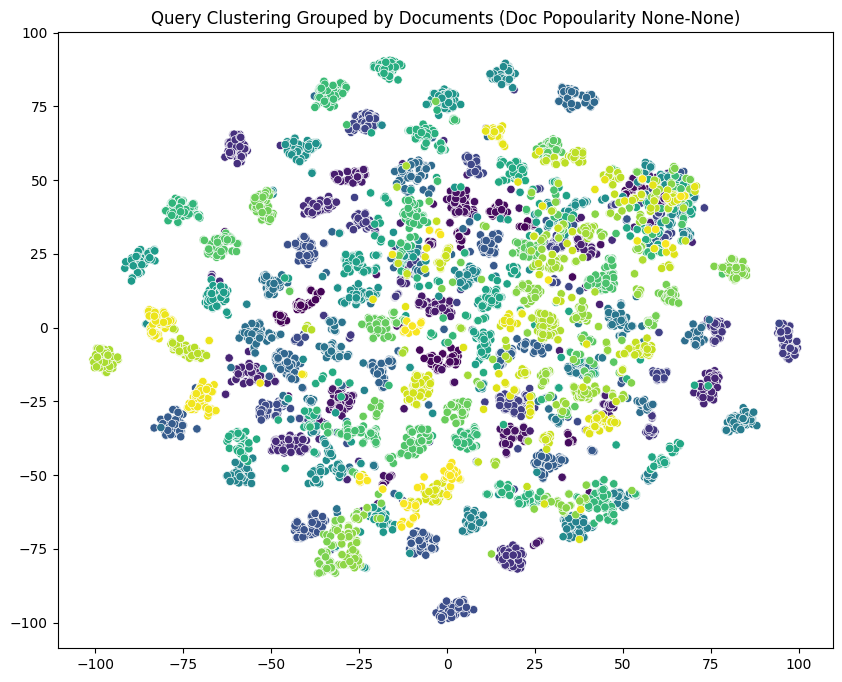

In [13]:
# Parameters
n_docs = 100
n_queries = 100
min_pop = None
max_pop = None

doc_embeddings = get_embeddings(n_docs, n_queries, min_pop, max_pop)

# 2D Reduction
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(doc_embeddings.numpy())
n_embeddings_per_doc = len(doc_embeddings) // n_docs
doc_labels = np.repeat(range(n_docs), n_embeddings_per_doc)

plt.figure(figsize=(10, 8))
plt.title(f'Query Clustering Grouped by Documents (Doc Popoularity {min_pop}-{max_pop})')
sns.scatterplot(x=embeddings_2d[:, 0], y=embeddings_2d[:, 1], hue=doc_labels.astype(str), palette='viridis', legend=False)

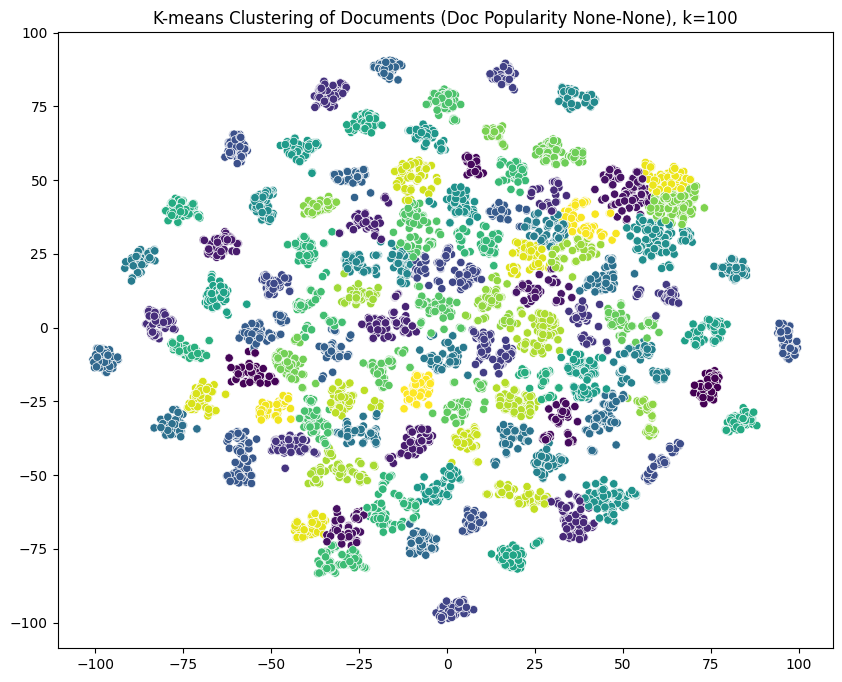

Silhouette Score for k-means:  0.54714817
Adjusted Rand Index: 0.6153267176706116
Normalized Mutual Information: 0.8227467756402316


In [23]:
from sklearn.cluster import KMeans

# Perform K-means clustering
kmeans = KMeans(n_clusters=n_docs, random_state=42)


clusters = kmeans.fit_predict(embeddings_2d)
plt.figure(figsize=(10, 8))
plt.title(f'K-means Clustering of Documents (Doc Popularity {min_pop}-{max_pop}), k={k}')
sns.scatterplot(x=embeddings_2d[:, 0], y=embeddings_2d[:, 1], hue=clusters, palette='viridis', legend=False)

plt.show()

from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score

silhouette_kmeans = silhouette_score(embeddings_2d, kmeans.labels_)
print("Silhouette Score for k-means: ", silhouette_kmeans)

# Calculate the Adjusted Rand Index
ari_score = adjusted_rand_score(doc_labels, kmeans_labels)
print("Adjusted Rand Index:", ari_score)

# Calculate the Normalized Mutual Information
nmi_score = normalized_mutual_info_score(doc_labels, kmeans_labels)
print("Normalized Mutual Information:", nmi_score)

## Export to TikZ/TeX

In [124]:
tikzplotlib.save(
    f'../plots/cluster_{n_queries}q_{n_docs}d_pop{min_pop}{"-" + str(max_pop) if max_pop is not None else ""}.tex',
    axis_width=r'\columnwidth', axis_height=r'6cm'
)

<Figure size 640x480 with 0 Axes>